In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
data = pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Introduction-to-Time-Series-forecasting/master/international-airline-passengers.csv",names=['times','passenger'],parse_dates=['times'], index_col='times')

In [12]:
data.head()

,passenger
times,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [14]:
# checking na 

data.isna().sum()

passenger    0
dtype: int64

In [15]:
# Step 2: Data Preprocessing
# Handle missing values, outliers, and format the data if needed
data = data.dropna()


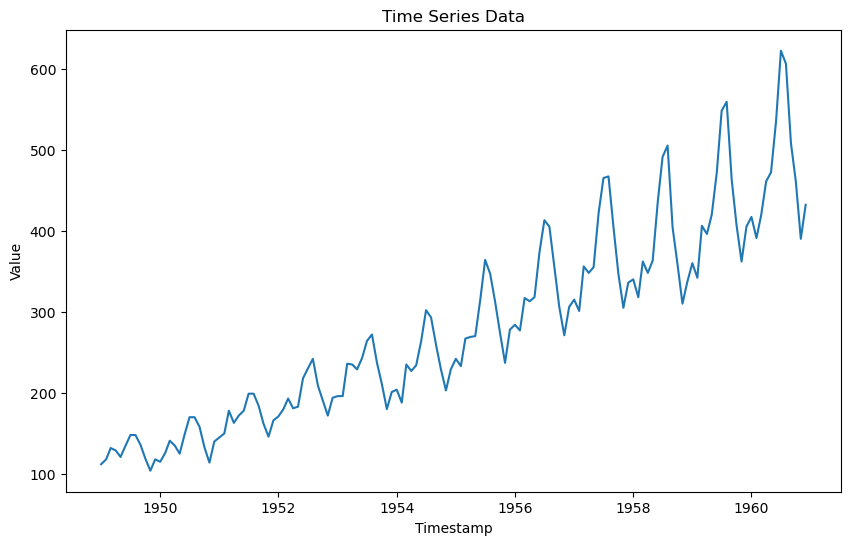

In [16]:
# Step 3: Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()


In [18]:
# Step 4: Check Stationarity
result = adfuller(data['passenger'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: 0.8153688792060655
p-value: 0.9918802434376413
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


In [19]:
# Step 5: Data Transformation
# If not stationary, perform differencing or other transformations
data_diff = data.diff().dropna()

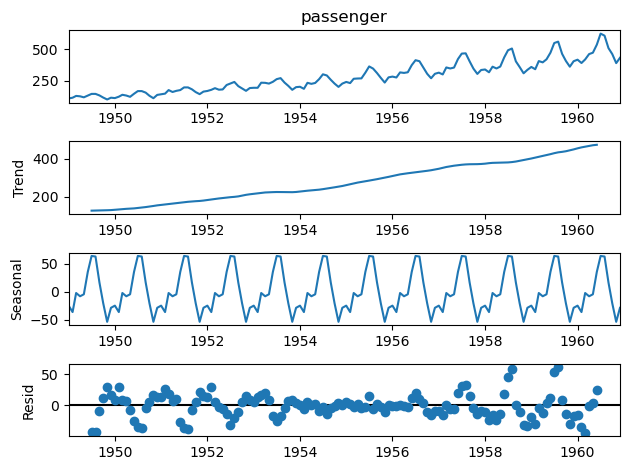

In [21]:
# Step 6: Decomposition
decomposition = seasonal_decompose(data['passenger'], model='additive')
decomposition.plot()
plt.show()

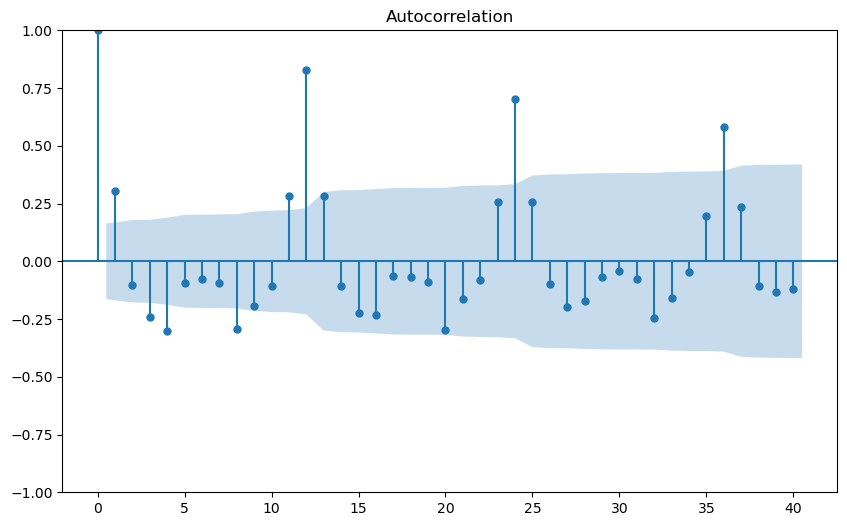

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


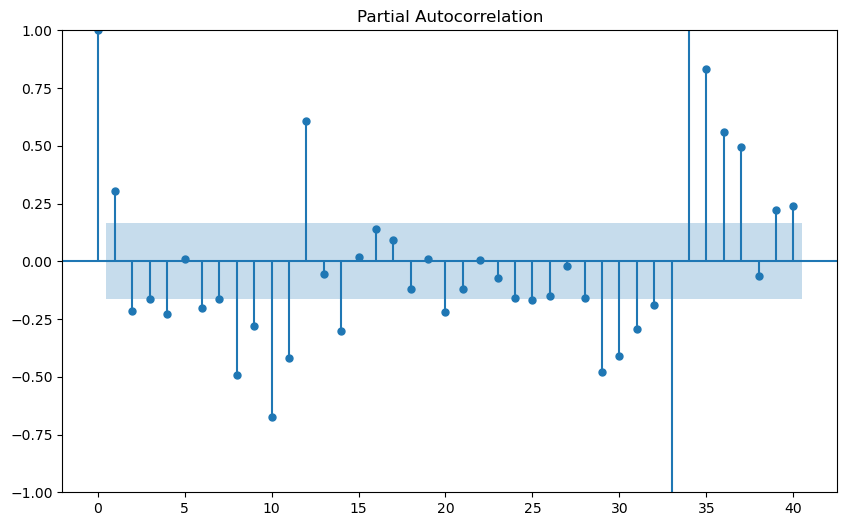

In [22]:
# Step 7: Autocorrelation and Partial Autocorrelation Analysis
plt.figure(figsize=(10, 6))
plot_acf(data_diff, lags=40, ax=plt.gca())
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(data_diff, lags=40, ax=plt.gca())
plt.show()

In [23]:
# Step 8: Model Selection
# Based on patterns and ACF/PACF analysis, choose a model (SARIMA in this example)
order = (1, 1, 1)  # ARIMA orders
seasonal_order = (1, 1, 1, 12)  # SARIMA seasonal orders

In [24]:
# Step 9: Model Training and Testing
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
results = model.fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26280D+00    |proj g|=  3.09266D-02

At iterate    5    f=  3.25399D+00    |proj g|=  2.63159D-02

At iterate   10    f=  3.25331D+00    |proj g|=  2.35062D-04

At iterate   15    f=  3.25331D+00    |proj g|=  6.40789D-05

At iterate   20    f=  3.25331D+00    |proj g|=  8.08098D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   1.707D-06   3.253D+00
  F =   3.2533052060643262     

CONVERG

In [25]:
# Step 10: Model Evaluation
forecast = results.forecast(steps=len(test_data))
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print('MAE:', mae)
print('RMSE:', rmse)

MAE: 23.55246759520585
RMSE: 30.138916488156354


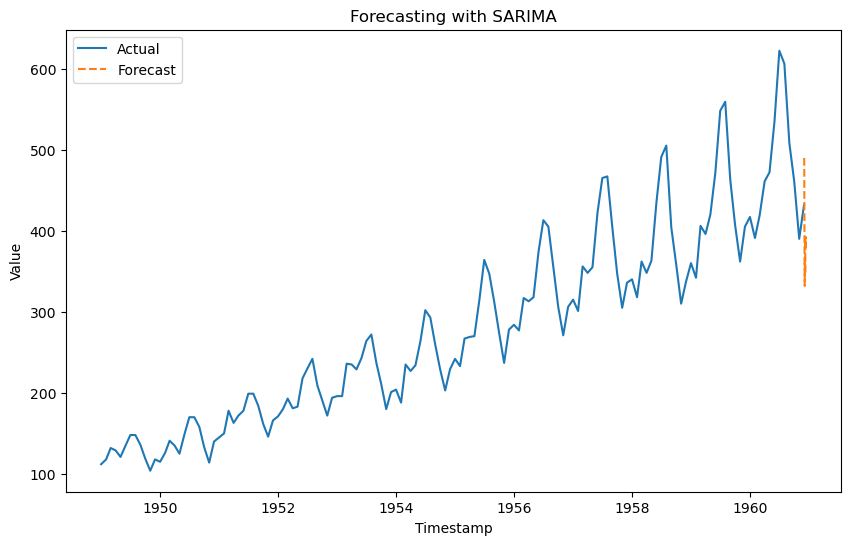

In [26]:
# Step 11: Forecasting
forecast_steps = 10
forecast = results.forecast(steps=forecast_steps)

# Step 12: Model Interpretation
plt.figure(figsize=(10, 6))
plt.plot(data, label='Actual')
plt.plot(pd.date_range(start=data.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast, label='Forecast', linestyle='dashed')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Forecasting with SARIMA')
plt.legend()
plt.show()

In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [29]:
# Step 11: Forecasting with ETS
model_ets = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12)
results_ets = model_ets.fit()
forecast_ets = results_ets.forecast(steps=forecast_steps)

# Step 12: Ensemble Forecasting (Simple Average)
ensemble_forecast = (forecast_sarima + forecast_ets) / 2




/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


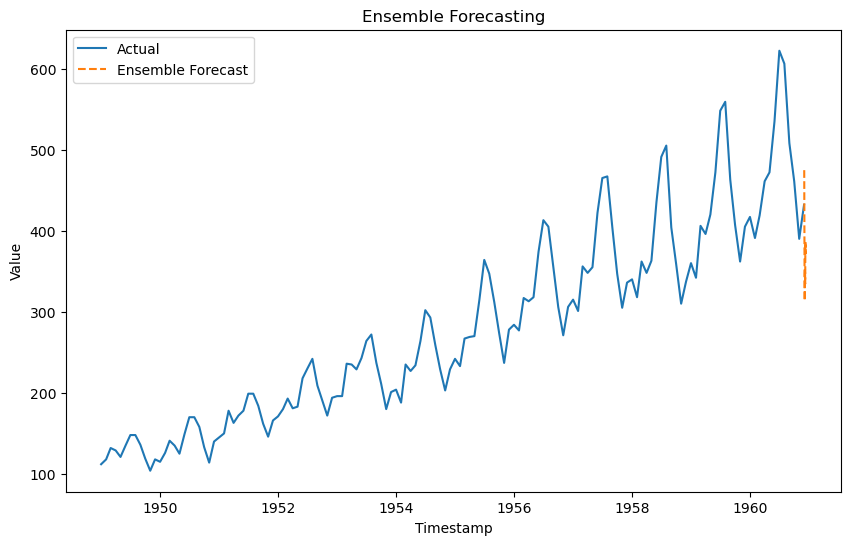

In [30]:
# Plot the ensemble forecast along with actual data
plt.figure(figsize=(10, 6))
plt.plot(data, label='Actual')
plt.plot(pd.date_range(start=data.index[-1], periods=forecast_steps+1, freq='D')[1:], ensemble_forecast, label='Ensemble Forecast', linestyle='dashed')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Ensemble Forecasting')
plt.legend()
plt.show()

In [53]:
from statsmodels.tsa.arima.model import ARIMA

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


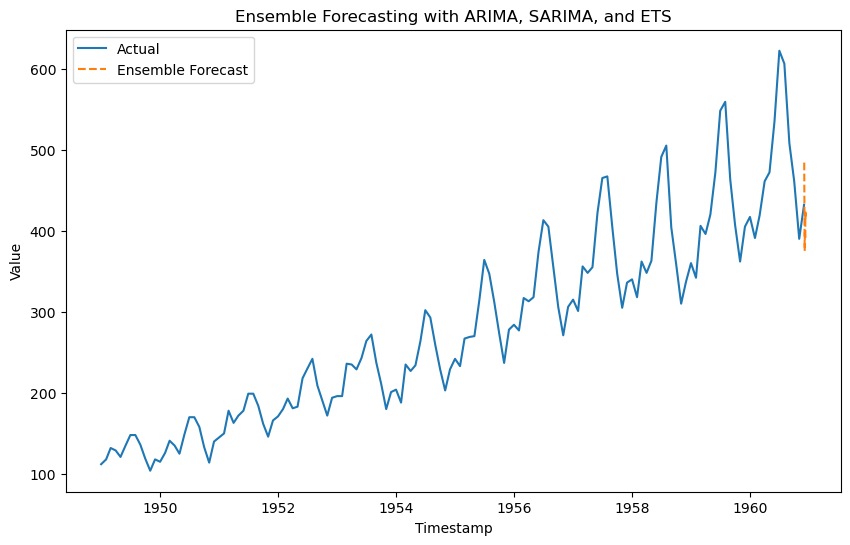

In [55]:
# Step 11: Forecasting with ARIMA
model_arima = ARIMA(train_data, order=(1, 1, 1))
results_arima = model_arima.fit()
forecast_arima = results_arima.forecast(steps=forecast_steps)

# Step 12: Ensemble Forecasting (Simple Average)
ensemble_forecast = (forecast_sarima + forecast_ets + forecast_arima) / 3

# Step 13 and Step 14: Same as previous example

# Plot the ensemble forecast along with actual data
plt.figure(figsize=(10, 6))
plt.plot(data, label='Actual')
plt.plot(pd.date_range(start=data.index[-1], periods=forecast_steps+1, freq='D')[1:], ensemble_forecast, label='Ensemble Forecast', linestyle='dashed')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Ensemble Forecasting with ARIMA, SARIMA, and ETS')
plt.legend()
plt.show()